# GSR Ingestion and Normalization

In [356]:
from datetime import datetime, time

import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## The Algorithm

The whole ingestion and normalization algorithm does this to all .csv files in the given directory:
   * interpolates to get regularly spaced samples
   * truncates to get identical durations
   * normalizes value range to range from 0 to 1

In [359]:
def normalized_series_from_dataframe(df):
    '''
    ingests and normalizes a dataframe into a normalized GSR response series with a datetime index
    input: dataframe
    output: pandas series
    '''
    x = df
    x['Name'] = x['Name'].apply(lambda x: ' '.join(x.split('-')[:2]))
    x['Timestamp'] = pd.to_datetime(x['Timestamp'],  format="%Y%m%d_%H%M%S%f")
    x = x.set_index('Timestamp')
    # shift back to midnight to normalize series timestamps
    norm_timedelta = x.index[0] - datetime(year=2019, month=2, day=27, hour=0, minute=0, second=0)
    x.index = x.index - norm_timedelta
    raw_gsr_column_name = list(x.columns)[-1]
    series = x[raw_gsr_column_name]
    series = series.rename(x['Name'][0])
    return series

def interpolate_series_timestamps(s):
    '''
    applies linear interpolation to series to give samples even spacing at every 25 milliseconds
    input: pandas series
    output: pandas series
    '''
    s = s.groupby(s.index).mean() # eliminate duplicate values by averaging repeated indexes 
    upsampled = s.resample('25L')
    interpolated = upsampled.interpolate(method='linear')
    return interpolated

def truncate_series_list_to_duration_of_shortest_series(series_list):
    '''
    truncates all files to be duration of shortest file
    input: list of dataframes
    output: list of dataframes with same ending timestamp
    '''
    last_timestamps = [x.index[-1] for x in series_list]
    min_time = min(last_timestamps)
    return [s.truncate(after=min_time) for s in series_list]

def ingest_dir_as_dataframes(the_dir):
    '''
    ingests a directory of .csv files and returns them as a list of dataframes
    '''
    path = the_dir
    all_files = glob.glob(path + "/*.csv")
    the_frames = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=2)
        the_frames.append(df)
    return the_frames

def normalize_series_range(the_series):
    the_series = the_series - the_series.min() # shift data from 0 to new max
    the_series = the_series.divide(the_series.max()) * 1.0
    return the_series

def post_process_column_names(df):
    names = [name.replace(' ', '').replace('Day', 'D') for name in df.columns]
    df.columns = names

def ingest_and_normalize_dir(the_dir):
    '''
    ingests a directory of .csv files and outputs a dataframe in which each column is a normalized 
    '''
    the_frames = ingest_dir_as_dataframes(the_dir)
    series_list = [normalized_series_from_dataframe(df) for df in the_frames]
    series_list = [interpolate_series_timestamps(s) for s in series_list]
    series_list = truncate_series_list_to_duration_of_shortest_series(series_list)
    series_list = [normalize_series_range(s) for s in series_list]
    df = pd.concat(series_list, axis=1, keys=[s.name for s in series_list])
    df.columns = [name.replace(' ', '').replace('Day', 'D') for name in df.columns]
    return df

In [360]:
df = ingest_and_normalize_dir('../../data/raw/GSR Audio Sensor Data- 9.3.19')

In [361]:
df.head()

,D5S2P2,D5S1P2,D7P1,D10P1,D4S1P2,D3S2P2,D6S2P1,D9S2P1,D8P2,D9S1P1,...,D9S1P2,D9S2P2,D8P1,D4S1P1,D3S2P1,D6S2P2,D7P2,D10P2,D5S1P1,D5S2P1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-02-27 00:00:00.000,0.995511,0.974168,0.184426,0.000000,0.675496,0.995275,1.000000,0.996656,0.965902,0.923713,...,0.730392,0.237066,0.429648,0.721657,0.693862,0.000000,0.949416,0.405239,1.000000,0.996313
2019-02-27 00:00:00.025,0.995735,0.974602,0.184174,0.001481,0.679067,0.995275,0.998031,1.000000,0.965902,0.928110,...,0.733543,0.236243,0.427136,0.721356,0.695590,0.002288,0.948473,0.405239,0.999554,0.996928
2019-02-27 00:00:00.050,0.995960,0.975035,0.183922,0.001111,0.683462,0.997637,0.997232,0.998328,0.965246,0.932507,...,0.736695,0.235420,0.426382,0.721054,0.695590,0.001144,0.947530,0.405239,0.999108,0.996313
2019-02-27 00:00:00.075,0.996184,0.975469,0.183670,0.000741,0.685660,1.000000,0.996432,0.996656,0.965464,0.936904,...,0.739846,0.234939,0.425628,0.720752,0.695590,0.002288,0.946586,0.405239,0.998662,0.996313
2019-02-27 00:00:00.100,0.996409,0.975903,0.183418,0.000370,0.697966,0.998819,0.995632,0.996656,0.965246,0.941301,...,0.742997,0.234457,0.424874,0.720450,0.695590,0.002288,0.945172,0.404830,0.999554,0.996518


All participants, each normalized between 0 and 1 individually:

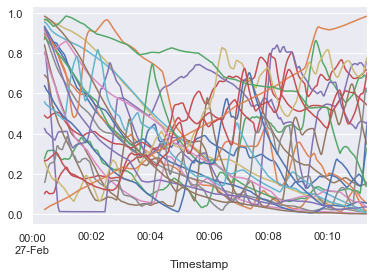

In [362]:
df.rolling(1000).mean().plot(legend=False)

Only downward-trending participants, each normalized between 0 and 1 individually:

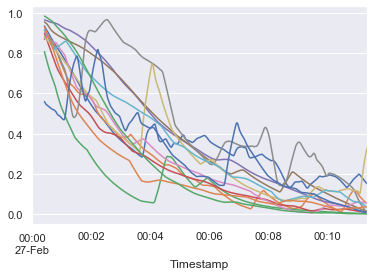

In [363]:
lower = [0, 1, 6, 7, 8, 9, 10, 11, 12, 16, 19, 24, 25]
cols = [df.columns[x] for x in lower]
lowers_df = df[cols]
lowers_df.rolling(1000).mean().plot(legend=False)